# Stock Price Prediction 

# I) Description of the problem

### On the problem.

* The problem of stock prediction concerns of being able to forecast a *Weakly Non stationary Time Series* so one can **sell** an active at a higher **Ask Price** that is was it's **Bid price** (buying at a smaller price than it was previously sold).


### On the properties of the data.

* Stocks, ETF's, hedge funds, can be modeled instantaneously as two Weakly Non stationary Time Series, one for *bid* prices and one for *ask* prices. By weakly Non stationary Time Series ($X(t)$), it is meant:

<center>
    First momentum invariance. (Trends in marked do not follow this)
</center>
$$E[X(t)] = E[X(t + \epsilon)]$$ <br/>




<center>
    Second momentum invariance. (Varying volatility of the market do not follow this)
</center>
$$C(X(t)) = C(X(t + \alpha)) = E[(X(t) - E[X(t)])(X(t + \epsilon) - E[X(t + \epsilon)])]$$ <br/>




<center>
    Bounded energy. (The very nature of inflation do not follow this)
</center>
$$E[|X(t)|^2] < \infty $$ <br/>




* So, one should interpret this data as not predictable for longer distances but, among several, one can depicts a few techniques to be able to predict those series. Namely:

    - Short term predictions: It transforms a non-stationary series in a locally stationary series. Thus, predictable.
    - Using the first order derivative ($r(t) = (x(t) - x(t - 1))$): It erases the 'memory' of a non-stationary series. This is also called **RETURNS** of a financial time series.


### On the financial data.

* **Bid's** and **Ask's** are updated at every new *order* in the *order book*, this is called *tick*. For visual chartists, analyzing this *tick* data is too cumbersome, so one of **many** ways of visualizing it, is in the form of **Open, Close, High, Low**, henceforth, nicknamed after *OCHL*. Those are defined as:

![title](assets/ochl.png)


* Among those who do trade stocks, we can find the ones so called *Scalpers* and the *Swing traders*, where, respectively, one places its buy/sell orders in the same day whereas the other waits for several days. We will be dealing with the former.

# II) Loading data

In [1]:
import requests
import quandl
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import *
from tqdm import tqdm, tqdm_notebook

%load_ext autoreload
%autoreload 2

In [2]:
api_key = os.environ['QUANDL_API_KEY']
metadata_filename = 'WIKI_metadata.csv'
dataset_filename = 'WIKI_dataset.csv'
dates_range = ['2000-12-31', '2018-12-31']

## Downloading and extracting the dataset

In [7]:
import zipfile
def get_data(url, filename, extract=True):
    r = requests.get(url, allow_redirects=True)
    filename = filename + '.zip' if extract else filename
    open(filename, 'wb').write(r.content)
    if not extract: return
    zipfile.ZipFile(filename, 'r').extractall('./')

In [8]:
get_data('https://www.quandl.com/api/v3/databases/WIKI/metadata?api_key=%s' % api_key, 
         metadata_filename)

get_data('https://www.quandl.com/api/v3/datatables/WIKI/PRICES/delta.json?api_key=%s' % api_key, 
         dataset_filename, extract=False)

In [9]:
metadata_df = pd.read_csv(metadata_filename)
dataset_df = pd.read_csv(dataset_filename)

In [10]:
metadata_df.sample(10)

,code,name,description,refreshed_at,from_date,to_date
1746,MA,"MasterCard Cl A (MA) Prices, Dividends, Split...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:11,2006-05-25,2018-03-27
2784,TGTX,"TG Therapeutics Inc. (TGTX) Prices, Dividends,...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:05,2010-05-03,2018-03-27
1098,FLR,"Fluor Corp. (FLR) Prices, Dividends, Splits an...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:11,2000-12-01,2018-03-27
2380,REG,"Regency Centers Corp. (REG) Prices, Dividends,...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:09,1993-10-29,2018-03-27
1193,GE,"General Electric Co (GE) Prices, Dividends, Sp...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:11,1962-01-02,2018-03-27
862,DRL,"Doral Financial Corp. (DRL) Prices, Dividends,...","<p>End of day open, high, low, close and volum...",2017-04-26 12:50:46,1992-02-25,2015-02-27
2084,OFIX,"Orthofix International N.V. (OFIX) Prices, Div...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:02,1992-04-24,2018-03-27
1712,LPG,"Dorian LPG Ltd. (LPG) Prices, Dividends, Split...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:08,2014-05-08,2018-03-27
1332,HF,"HFF (HF) Prices, Dividends, Splits and Trading...","<p>End of day open, high, low, close and volum...",2018-03-27 21:45:59,2007-01-31,2018-03-27
2945,UNP,"Union Pacific Corp (UNP) Prices, Dividends, Sp...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:12,1980-01-02,2018-03-27


In [11]:
dataset_df

,"{""data"":{""files"":[]",latest_full_data:null}}


* Since the api for `get`'ing seems to be not working, we can use the **quandl** module to download the dataset.



* The WIKI dataset has a huge variety of stocks and assets, so, for now, we'll be dealing with only **one** for regression.


In [12]:
ASSET_FOR_REGRESSION = 'FLXS'

quandl.ApiConfig.api_key = api_key

dataset_df = quandl.get_table('WIKI/PRICES', ticker = [ASSET_FOR_REGRESSION], 
                        date = {'gte': dates_range[0], 'lte': dates_range[1]},
                        paginate=True).reset_index(drop=True)

dataset_df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,FLXS,2018-03-27,36.50,37.2500,35.7200,36.08,26675.0,0.0,1.0,36.50,37.2500,35.7200,36.08,26675.0
1,FLXS,2018-03-26,35.54,36.8400,35.3201,36.53,58004.0,0.0,1.0,35.54,36.8400,35.3201,36.53,58004.0
2,FLXS,2018-03-23,36.44,36.4950,34.7400,35.03,58287.0,0.0,1.0,36.44,36.4950,34.7400,35.03,58287.0
3,FLXS,2018-03-22,36.99,37.3338,36.3050,36.45,22048.0,0.0,1.0,36.99,37.3338,36.3050,36.45,22048.0
4,FLXS,2018-03-21,37.45,37.8900,37.2800,37.41,14861.0,0.0,1.0,37.45,37.8900,37.2800,37.41,14861.0


## Peaking on the data

In [16]:
from pandas.plotting import register_matplotlib_converters
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

data_to_plot = dataset_df[dataset_df.ticker == ASSET_FOR_REGRESSION][['open', 'high', 'low', 'close', 'date']].copy()
data_to_plot['date'] = data_to_plot.date.map(mdates.date2num).copy()

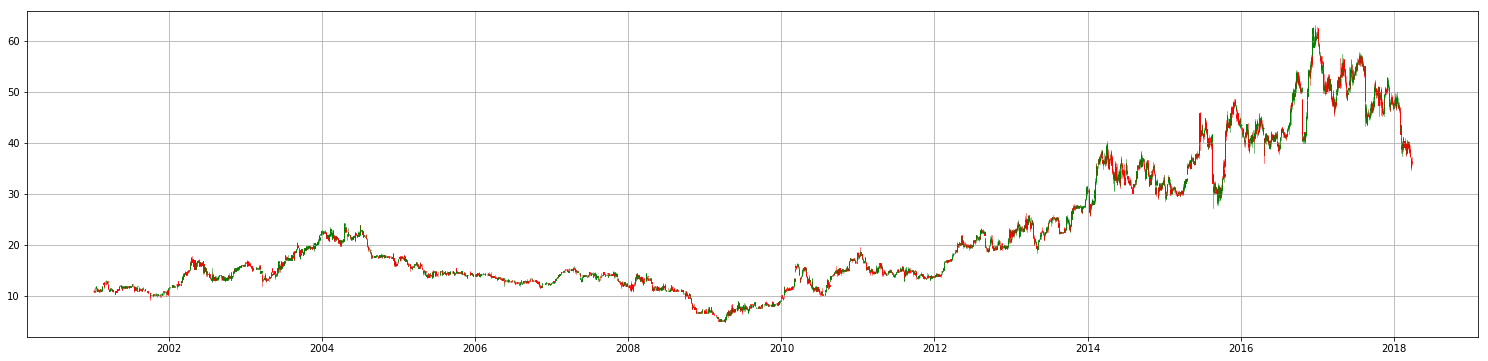

In [17]:
plt.figure(figsize=(26, 6))
ax = plt.subplot()
candlestick_ohlc(ax, data_to_plot[['date', 'open', 'high', 'low', 'close']].values, width=.5, colorup='g', colordown='r')
ax.xaxis_date()
ax.grid()
plt.show()

del data_to_plot

## Train, Validation and test split

* A **true** train/val/test split is one with no **leakage** to/from train/validation/test. 


* So ideally, the test should be another symbol (*e.g.*: train with FLXS, validate in another period of time using another asset). 


* But this would only prove the robustness and generalization of our model, while possibly, not maximizing profits in a single asset. Besides, multiple asset analysis is better done using a **Modern Portfolio Theory** (MPT, as proposed by *Markowitz*). 


* Thus, the split will be done in order to only avoid **lookahead bias** (train with day 1 and day 3, and test with day 2).


* Blocked Time Series Splits scheme of cross validation and training of our model will be used. We will also use a training in the whole data giving equal importance to all the data.


![title](assets/cross_validation2.png)

In [18]:
TRAIN_VAL_PERCENTAGE = 0.90
TEST_PERCENTAGE = 1 - TRAIN_VAL_PERCENTAGE

full_dates_range = pd.date_range(start=dates_range[0], end=dates_range[1]).sort_values()

train_val_date_range = full_dates_range[:int(len(full_dates_range) * TRAIN_VAL_PERCENTAGE)].sort_values()
test_date_range = pd.DatetimeIndex(set(full_dates_range) - set(train_val_date_range)).sort_values()

In [19]:
dataset_df.loc[dataset_df.date.isin(train_val_date_range), 'set'] = 'TRAIN_VAL'
dataset_df.loc[dataset_df.date.isin(test_date_range), 'set'] = 'TEST'

In [22]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits, train_val_percentage=0.8):
        self._train_val_percentage = train_val_percentage
        self._n_splits = n_splits
    
    @property
    def n_splits(self):
        return self._n_splits
    
    def split(self, X):
        n_samples = len(X)
        k_fold_size = n_samples // self._n_splits
        indices = np.arange(n_samples)

        for i in range(self._n_splits):
            begin = i * k_fold_size
            end = begin + k_fold_size
            mid = int(self._train_val_percentage * (end - begin)) + begin
            yield indices[begin:mid], indices[mid:end]

# III) Feature engineering

* As discussed in the first section, it is useful to transform the OCHL features to something manageable mathematically, such as, a (locally) stationary time series.


In [25]:
primary_features_columns = ['open', 'high', 'low', 'close', 'volume']

In [28]:
features_df = dataset_df[primary_features_columns + ['ticker', 'set', 'date']].copy()

## Analytical features

### Daily returns.

* One can use the relative returns of one single day as feature, since it is a first order derivative, thus, conveying stationarity to out time series.

$$\frac{X(t_{close})}{X(t_{open})} - 1$$

In [29]:
features_df['daily_returns'] = (features_df.close / features_df.open) - 1

### Log returns.

* Among the advantages explored in the **section I)** of using returns instead of the raw data, we can further improve the feature of time series so it displays desirable statistical properties. One usual transform is known as **Log-returns**, defined as follows:


$$log(\frac{X(t)}{X(t-1)})$$


* The desirable properties of using log-returns can be summed in as being prone to follow a normal distribution and being able to "accumulate" returns over time with simple additions instead of multiplications)

In [30]:
def log_returns(dataframe):
    sorted_dataframe = dataframe.sort_values(by='date')
    sorted_dataframe['log_returns'] = np.log(sorted_dataframe.close / sorted_dataframe.close.shift(1))
    return sorted_dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(log_returns).droplevel(0)

## Market Features (Techinical indicators)

* For traders who are used to manually trade, It's often used a common analysis called **Technical Analysis**, in which allegedly, it is possible to infer market movements such as *momentum*, *overbought*, *oversold*, *breakout break* and *support breakout* through **technical indicators** such as (*e.g.* MACD, RSI, EMA, Bollinger Bands, Stochastic oscillators).



* There are **no**$^{I}$  proves so far that technical indicators have any real predictive power over the market besides the mere fact that human traders, hedge funds and firms tend to use them, so, by the efficient market hypothesis, the market will react in accordance with those buyers and sellers.


* Thus, we are going to use one of those indicators because it can at least predict if traders are using it too much or otherwise.




<sup>$^{I}$: *Burton G. Malkiel*, A randon walk down wall street.<sup>

### Price-Volume Trend

* Sharp changes in the price that follows a sharp change in volume usually represents a **resistance** or **support**, meaning that traders will consider the market overbought (or oversold) and start to sell (or buy).


* On Balance Volume (OBV) Is an indicator that simply adds or subtracts the volume from a accumulator depending on the return of the current day.

In [32]:
def on_balance_volume(dataframe):
    sorted_dataframe = dataframe.sort_values(by='date')
    previous_row = None
    def _compute_obv_for_row(row):
        nonlocal previous_row
        if previous_row is not None:
            row['obv'] = previous_row['obv'] + row['volume'] if row['close'] > previous_row['close'] else\
                         previous_row['obv'] - row['volume'] if row['close'] < previous_row['close'] else\
                         previous_row['obv']
        else:
            row['obv'] = np.nan
            previous_row = row.copy()
            previous_row['obv'] = .0
        return row

    return sorted_dataframe.apply(_compute_obv_for_row, axis=1)

features_df = features_df.groupby('ticker')\
    .apply(on_balance_volume).reset_index(drop=True)

### Normalization

* In order give no priors to our models, the available features will be normalized by their respective standard deviation in the train so they have the same *a-priori* importance, since their power will always be 1.

In [33]:
# Save standard deviations for reconstructing the data later.
standard_deviation = {}

def normalize(dataframe):
    global standard_deviation
    asset = dataframe.ticker.iloc[0]
    
    feature_columns = primary_features_columns + ['daily_returns', 'log_returns', 'obv']
    _features_df = dataframe[feature_columns]
    
    standard_deviation[asset] = _features_df[dataframe.set == 'TRAIN_VAL'].std()
    _features_df = _features_df.div(standard_deviation[asset])
    
    dataframe[feature_columns] = _features_df
    return dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(normalize).reset_index(drop=True)

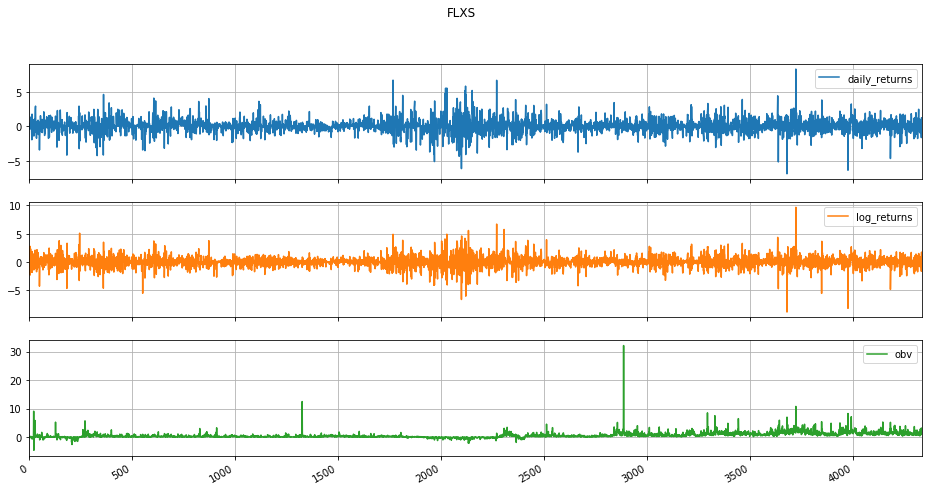

In [34]:
features_df[features_df.ticker == ASSET_FOR_REGRESSION][['daily_returns', 'log_returns', 'obv']]\
    .plot(subplots=True, figsize=(16, 8), grid=True, title=ASSET_FOR_REGRESSION)
plt.show()

# IV) Training

## Regression task

* Windows of ten days of features with 7 days of overlap will be used for the regression task.

In [36]:
from collections import namedtuple

In [38]:
WINDOW_SIZE = 5
OVERLAP = 2

In [42]:
Sample = namedtuple('Sample', ['windowed_features', 'scalar_features', 'target'])

In [43]:
def get_samples_and_targets(
        dataframe, *, 
        target_column, windowed_features_columns=[], 
        scalar_features_columns=[], window_size=5, overlap=3
):
    samples = []
    for idx in range(window_size, len(dataframe), window_size - overlap):
        windowed_features = dataframe.iloc[idx - window_size:idx][windowed_features_columns].values.copy()
        windowed_features -= np.mean(windowed_features)
        
        scalar_features=dataframe.iloc[idx - 1][scalar_features_columns].values.copy()
        target=dataframe.iloc[idx][target_column].copy()
        samples.append(Sample(windowed_features, scalar_features, target))
    return samples

### Separate the test samples

In [44]:
test_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                       (features_df.set == 'TEST')]

test_set = test_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [45]:
test_samples = get_samples_and_targets(
    test_set, 
    target_column='log_returns',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=WINDOW_SIZE, overlap=(WINDOW_SIZE-1))

### Create samples for train

In [46]:
train_val_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                            (features_df.set == 'TRAIN_VAL')]

train_val_set = train_val_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [47]:
train_val_samples = get_samples_and_targets(
    train_val_set, 
    target_column='log_returns',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=WINDOW_SIZE, overlap=OVERLAP)

### Create simple model for linear regression

In [48]:
import torch

In [50]:
FLATTENED_SAMPLE_SIZE = train_val_samples[0].windowed_features.ravel().shape[0] +\
                        train_val_samples[0].scalar_features.shape[0]

* Defining the model
* The first model will be a simple linear regression trained with gradient descent, where the input will be a flattened version of our samples.


$$output = \boldsymbol{W} * input + b$$
where $\boldsymbol{W}$ and $\boldsymbol{b}$ are parameters to be learned.
 
And the gradient descent can be noted as:
$$\boldsymbol{W} = \boldsymbol{W} - lr * \frac{\delta{loss}}{\delta{\boldsymbol{W}}}$$


Multiple variations of the former are found in the literature (we can add *momentum*, adaptive learning rates, clipping in gradients etc). 

We are going to use the Gradient descent with Adaptive momentum and Adaptive learning rate -**Adam**- variation.

In [52]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.w = torch.nn.Parameter(np.sqrt(input_size) * torch.randn(output_size, input_size))
        
    @staticmethod
    def flatten_samples(samples):
        samples = [samples] if not isinstance(samples, list) else samples
        flattened_samples =\
            map(lambda sample:\
                np.concatenate([sample.windowed_features.ravel(),
                                sample.scalar_features]).astype('float32'), samples)
        return torch.FloatTensor(list(flattened_samples))

    def forward(self, samples):
        x = self.flatten_samples(samples)

        y = x @ self.w.t()
        return y.view(-1)
        

* Functions for Training, validating and ploting the loss

In [57]:
def batch_generator(iterable, batch_size):
    l = len(iterable)
    for start_idx in range(0, l, batch_size):
        yield iterable[start_idx:min(start_idx + batch_size, l)]

In [58]:
def train_on_batch(model, criterion, optimizer, batch_samples):
    target = torch.FloatTensor(list(map(lambda sample: sample.target, batch_samples)))
    target_pred = model(batch_samples)
    loss = criterion(target, target_pred)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.detach().numpy()

In [59]:
def train_epoch(model, criterion, optimizer, train_samples, batch_size):
    losses = [
        train_on_batch(model, criterion, optimizer, batch_train_samples)\
        for batch_train_samples in batch_generator(train_samples, batch_size)
    ]
    return np.mean(losses)

In [60]:
def validate(model, criterion, validation_samples):
    with torch.no_grad():
        target = torch.FloatTensor(list(map(lambda sample: sample.target, validation_samples)))
        target_pred = model(validation_samples)
        loss = criterion(target, target_pred)
        return loss.detach().numpy()

In [61]:
def train_n_epocs(model, criterion, optimizer, train_val_samples, train_splits, 
                  n_epocs, metrics=None, batch_size=32):
    if metrics is None:
        metrics = {'train_loss': [], 'validation_loss': []}
    
    for i in tqdm_notebook(range(n_epocs), desc='epoch'):
        train_loss = 0
        validation_loss = 0
        
        for train_samples_idx, validation_samples_idx in train_splits.split(train_val_samples):
            train_samples = [train_val_samples[i] for i in train_samples_idx]
            validation_samples = [train_val_samples[i] for i in validation_samples_idx]
            
            train_loss += train_epoch(
                model, criterion, optimizer, train_samples, batch_size)
            validation_loss += validate(
                model, criterion, validation_samples)

        train_loss = float(train_loss / train_splits.n_splits)
        validation_loss = float(validation_loss / train_splits.n_splits)
        
        metrics['train_loss'].append(train_loss)
        metrics['validation_loss'].append(validation_loss)
    return metrics

In [62]:
plot_metrics = plot_metrics_factory()

### Training linear regression v1

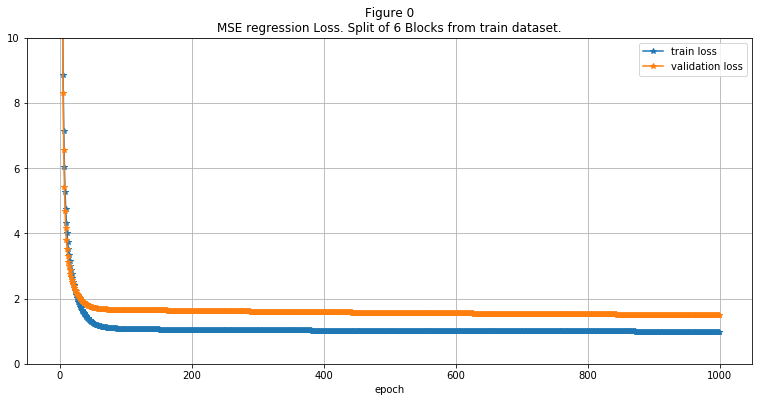

In [63]:
model = LinearRegression(FLATTENED_SAMPLE_SIZE, 1)
train_splits = BlockingTimeSeriesSplit(n_splits=6, train_val_percentage=TRAIN_VAL_PERCENTAGE)
criterion = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
metrics = train_n_epocs(model, criterion, optimizer, train_val_samples, train_splits, n_epocs=1000)

plot_metrics(metrics, [0, 10], 'Split of 6 Blocks from train dataset.')

metricsv1 = metrics
modelv1 = model

### Test predictions:

In [64]:
log_returns = model(test_samples).detach().numpy()

In [65]:
previous_close = test_set.iloc[WINDOW_SIZE-2].close
predicted_close_prices = reconstruct_close_prices_from_log_returns(
    previous_close, log_returns, standard_deviation[ASSET_FOR_REGRESSION].log_returns)

close_prices = test_set.iloc[WINDOW_SIZE-2:].close.values

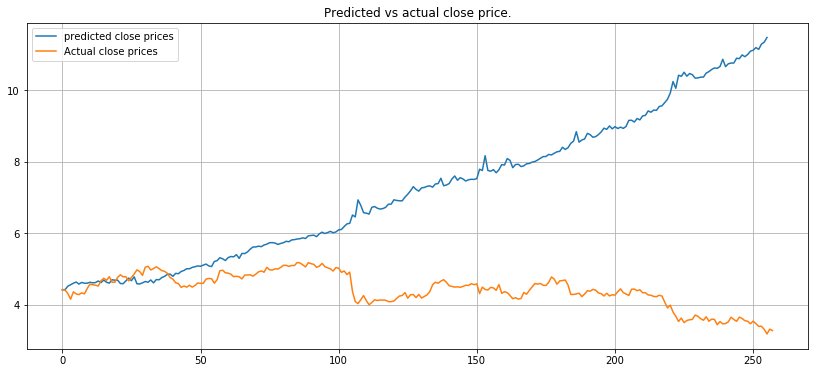

In [66]:
plt.figure(figsize=(14, 6))
plt.title('Predicted vs actual close price.')
plt.grid()
plt.plot(predicted_close_prices, label='predicted close prices')
plt.plot(close_prices, label='Actual close prices')
plt.legend()
plt.show()

### Training linear regression v2
* Since this model is a simple linear regression, we can try to fit it in all the data instead of multiple split blocks from the training set.

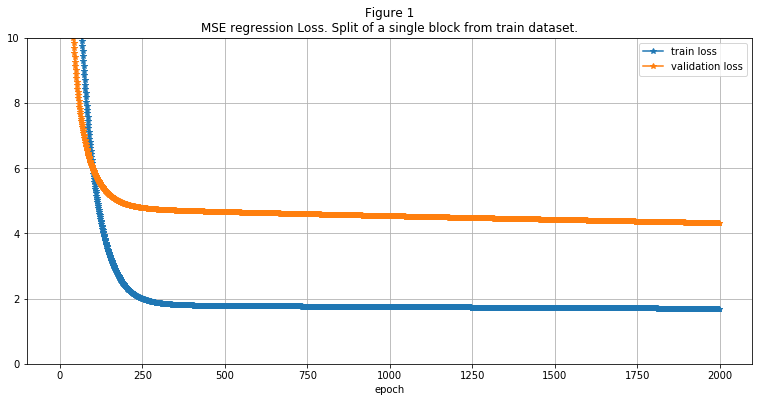

In [846]:
model = LinearRegression(FLATTENED_SAMPLE_SIZE, 1)
train_splits = BlockingTimeSeriesSplit(n_splits=1, train_val_percentage=TRAIN_VAL_PERCENTAGE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
metrics = train_n_epocs(model, criterion, optimizer, train_val_samples, train_splits, n_epocs=2000)

plot_metrics(metrics, [0, 10], 'Split of a single block from train dataset.')

metricsv2 = metrics
modelv2 = model

In [847]:
log_returns = model(test_samples).detach().numpy()

In [848]:
previous_close = test_set.iloc[WINDOW_SIZE - 2].close
predicted_close_prices = reconstruct_close_prices_from_log_returns(
    previous_close, log_returns, standard_deviation[ASSET_FOR_REGRESSION].log_returns)

close_prices = test_set.iloc[WINDOW_SIZE - 2:].close.values

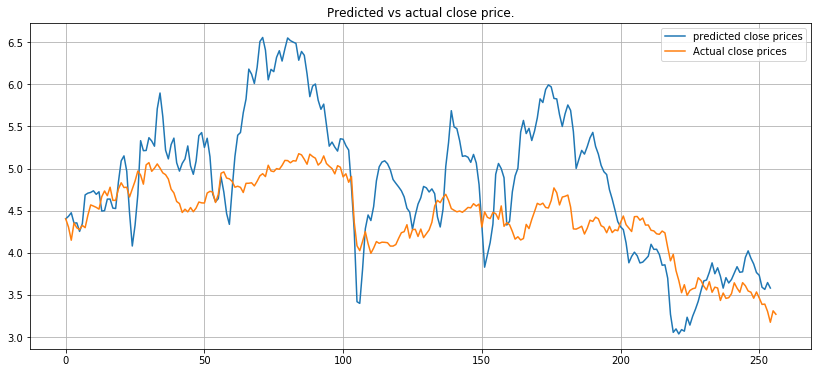

In [849]:
plt.figure(figsize=(14, 6))
plt.title('Predicted vs actual close price.')
plt.grid()
plt.plot(predicted_close_prices, label='predicted close prices')
plt.plot(close_prices, label='Actual close prices')
plt.legend()
plt.show()

### Analysis

#### On the model

* By looking at the four previous plots, It is possible to notice that even with small and simple models we would need to chose between two, Having robustness or Having specificity. In the first model, We trained validated with a more diverse data, whereas in the second, the model could overfit in most of the train data which in this particular case made the model more robust only because the model is a simple linear regression.



* **Having robustness** of the model (being guaranteed that the model can generalizes **"reasonably"** well in the test, by having more diverse data, without leakage, which might be the case for trading, since we want to have *some* assurance that in the test set, it will perform the way the trader expect.
    
    - hypothesis testing
        - $H_0\ (Null\ hypothesis)$ = Buy and hold strategy, profit will be no more than the market value discounted the systematic volatility
        - $H_1$ = Buy when model says the returns were negative and then became positive. Having a certainty that the model is right about the change of sight in the returns at most TRAIN_VAL_PERCENTAGE%





* **Having specificity** Being able to perform better (than with a robust model) in the first month after the last day of training, but having to fine-tune the model often.

#### On how to evaluate

* The way we're evaluating is not appropriate since, small errors in the return will accumulate and make the resultant time series diverge.


* One better way to evaluate the model(s) is defining a **strategy** (set of rules defining when to buy/sell/hold and the how much), sticking with it, and plotting its **equity curve**, comparing the profit of this strategy with the buy and hold.

## Simple hybrid fully convolutional and regressor model.

* A **convolutional** "layer" works simply by creating features out of inputs using convolution kernels, also called filters ([Image Kernel Convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing))), so, by stacking multiple layers, one can expect to extract higher and higher order features from the input.


* A Fully convolutional network is expected to have a only small set of features at the end of its last layer so the classification (or regression) can be made using those features, without any "flatten" operation followed by a linear regressor.

* The following model will have two parts main parts, one for the `windowed features` and another for `scalar features` and one `final regressor`:
    - windowed features => A fully convolutional model, where the channels are going represent each windowed feature (open, close, high, low), outputing a single feature value that will be concatenated with the second part of the model.
    <br/><br/>
    - scalar features => A linear regression with the custom built features (log returns, daily returns and obv),  outputing a single feature value that will be concatenated with the first part of the model.
    <br/><br/>
    - final regressor => Simple linear regression upon the output of the scalar features and windowed features outputing the expected return at a given day.
<br/><br/>
* The train is done using the same gradient descent used with the previous model.
<br/><br/>
* We use a bigger window as input, as we're using pooling layers and we want to extract some longer term features.

In [67]:
WINDOW_SIZE = 6
OVERLAP = 3

### Separate the test samples

In [68]:
test_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                       (features_df.set == 'TEST')]

test_set = test_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [69]:
test_samples = get_samples_and_targets(
    test_set, 
    target_column='log_returns',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=WINDOW_SIZE, overlap=(WINDOW_SIZE-1))

### Create samples for train

In [70]:
train_val_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                            (features_df.set == 'TRAIN_VAL')]

train_val_set = train_val_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [71]:
train_val_samples = get_samples_and_targets(
    train_val_set, 
    target_column='log_returns',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=WINDOW_SIZE, overlap=OVERLAP)

### Define the Model

In [855]:
input_channels = train_val_samples[0].windowed_features.shape[-1]
input_linear_size = len(train_val_samples[0].scalar_features)

In [72]:
class ConvLinearModel(torch.nn.Module):
    def __init__(self, input_channels, input_linear_size, output_size):
        super().__init__()
        self._input_linear_size = input_linear_size

        self._convolutional_regressor = torch.nn.Sequential(
            self._create_convolution_block(input_channels=input_channels, output_channels=16, kernel_size=3),
            torch.nn.Conv1d(in_channels=16, out_channels=output_size, kernel_size=2),
            torch.nn.AdaptiveAvgPool1d(4) # pooling(input / 4)
        )

        self._linear_regressor = torch.nn.Sequential(
            torch.nn.Linear(input_linear_size, output_size, bias=False),
            torch.nn.ReLU()
        )

        self._output_regressor = torch.nn.Linear(2 * output_size, output_size, bias=False)

    @staticmethod
    def _create_convolution_block(input_channels, output_channels, kernel_size):
        return torch.nn.Sequential(
            torch.nn.Conv1d(input_channels, output_channels, kernel_size, bias=False, ),
            torch.nn.Dropout(0.5),
            torch.nn.AvgPool1d(2),
        )

    def forward(self, samples):
        windowed_features = torch.FloatTensor([sample.windowed_features.T for sample in samples])
        scalar_features = torch.FloatTensor([sample.scalar_features for sample in samples])

        convolved_signal = self._convolutional_regressor(windowed_features)
        convolved_signal = convolved_signal.view(-1, 1)

        regressed_signal = self._linear_regressor(scalar_features.view(-1, self._input_linear_size))
        regressed_signal = regressed_signal.view(-1, 1)

        return self._output_regressor(torch.cat([regressed_signal, convolved_signal], dim=-1)).view(-1)

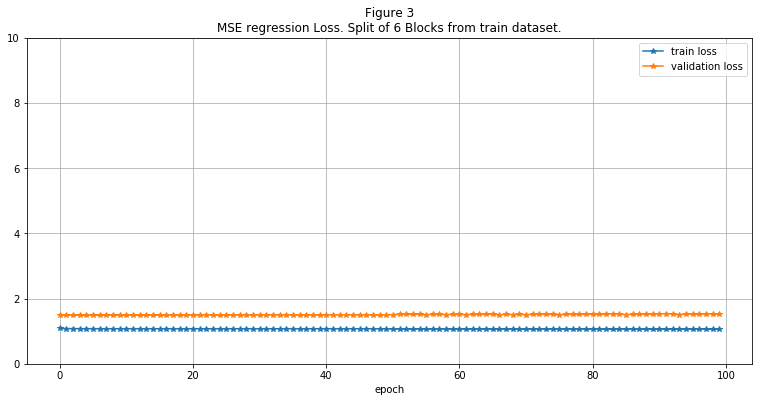

In [859]:
model = ConvLinearModel(input_channels, input_linear_size, 1)

train_splits = BlockingTimeSeriesSplit(n_splits=6, train_val_percentage=TRAIN_VAL_PERCENTAGE)
criterion = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=.07)
metrics = train_n_epocs(model, criterion, optimizer, train_val_samples, train_splits, n_epocs=50, batch_size=8)

optimizer = torch.optim.SGD(model.parameters(), lr=.03)
metrics = train_n_epocs(model, criterion, optimizer, train_val_samples, train_splits, n_epocs=50, batch_size=8, metrics=metrics)

plot_metrics(metrics, [0, 10], 'Split of 6 Blocks from train dataset.')

metricsv3 = metrics
modelv3 = model

In [860]:
log_returns = model(test_samples).detach().numpy()

In [861]:
previous_close = test_set.iloc[WINDOW_SIZE-2].close
predicted_close_prices = reconstruct_close_prices_from_log_returns(
    previous_close, log_returns, standard_deviation[ASSET_FOR_REGRESSION].log_returns)

close_prices = test_set.iloc[WINDOW_SIZE-2:].close.values

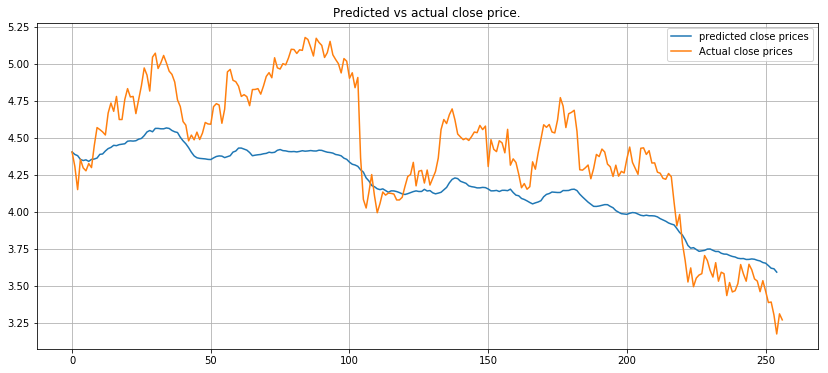

In [862]:
plt.figure(figsize=(14, 6))
plt.title('Predicted vs actual close price.')
plt.grid()
plt.plot(predicted_close_prices, label='predicted close prices')
plt.plot(close_prices, label='Actual close prices')
plt.legend()
plt.show()

### Analysis

* The same analisys over how to evaluate the model could be made here (one needs a **strategy** and plot the equity curve), but since strategy analisys is beyond scope.


- There is still one curious observation on all the training. And it regards the final train loss.


- The train loss in every case is trying to converge to **1** in particular due to:
    - Any linear method for prediction can be decomposed in a predictable part and a inherently random part$^I$
    - If the signal is inherently random or the models are not able to accurately forecast the time series, only the random portion of the data is left.
    - Since the data was normalized by its standard deviation, its energy should sum up to 1, and if the random part is the most significant part if the signal, that will be the power if the signal, 
    - thus, most(not all) of the model predictions are going to be random, so the Mean square error (model Loss) is going to be the signal energy, 1.
    
<sup>$^{I}$: [Wold's decomposition](https://en.wikipedia.org/wiki/Wold%27s_theorem) 

S = Predictable + \epsilon => std 1
